## Imports

In [1]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorSampler


## Loss function

In [36]:
# MMR method implemented

def method(data, k):
    x_data = data[0]
    y_data = data[1]

    k_evaluated_at_data_points = np.zeros((len(x_data), len(x_data)))
    for i in range(len(x_data)):
        for j in range(len(x_data)):
            k_evaluated_at_data_points[i, j] = k(x_data[i], y_data[j])

    def trial_function_evaluated_at_data_points(a, b):
        result = np.zeros_like(a)
        result += b
        for i in range(len(a)):
            result += a[i]*k_evaluated_at_data_points[:, i]
        return result
    
    def trial_function(x, a, b):
        result=b
        for i in range(len(a)):
            result += a[i]*k(x, y_data[i])
        return result

    def loss_function(alphas):
        b = alphas[0]
        a = alphas[1:]
        y_trial = trial_function_evaluated_at_data_points(a, b)
        result = np.sum((y_data-y_trial)**2)
        return result
    
    x0 = np.append(np.array([np.sum(x_data)/len(x_data)]), np.zeros_like(y_data))
    
    minimization = minimize(loss_function, x0=x0)
    b = minimization.x[0]
    a = minimization.x[1:]

    def optimized_trial_function(x):
        return trial_function(x, a, b)
    
    return optimized_trial_function


## Kernel

### Kernel library

In [13]:
#classical kernel, k(x, y) = exp(-(x-y)**2/(2*sigma**2))
def K_classical(sigma):
    def k(x, y):
        return np.exp(-(x-y)**2/(2*sigma**2))
    return k

#quantum kernel with a single Rx gate on every qubit as a feature map
def K_simple_RX(N):
    def U(x, N):
        qc = QuantumCircuit(N, name=r"U")
        for n in range(N):
            qc.rx(x, n)
        return qc

    def U_dagger(x, N):
        qc = QuantumCircuit(N, name=r"$U^\dagger$")
        for n in range(N):
            qc.rx(-x, n)
        return qc

    def kernel_circuit(N):
        qc = QuantumCircuit(N, name=r"$\kappa$")
        x = Parameter("x")
        y = Parameter("y")

        qc.append(U(y, N), range(N))
        qc.append(U_dagger(x, N), range(N))

        qc.measure_all()
        return qc
    
    def k(x, y):
        n_shots = 1024
        sampler = StatevectorSampler()
        circuit = kernel_circuit(N)

        # Transpile circuit
        pm = generate_preset_pass_manager(optimization_level=1)
        pm.run(circuit)

        # Run using V2 sampler
        result = sampler.run([(circuit, [x, y])], shots=n_shots).result()

        # Access result data for PUB 0
        data_pub = result[0].data
        counts = data_pub.meas.get_counts()

        # Calculate the probability of the all zeros state
        all_zeros = '0' * N
        if all_zeros not in counts:
            return 0
        return counts[all_zeros] / n_shots
    
    return k

### Visualize Kernel

In [14]:
def kernel_subplot(ax, k, N, grid_res=15):
    xs = np.linspace(0, 2*np.pi, grid_res)
    KK = np.array([[k(x, y) for x in xs] for y in xs])

    ax.set_title(rf"$\kappa(x, y)$ for $N={N}$ qubits")
    ax.imshow(KK, extent=(0, 2*np.pi, 0, 2*np.pi))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])

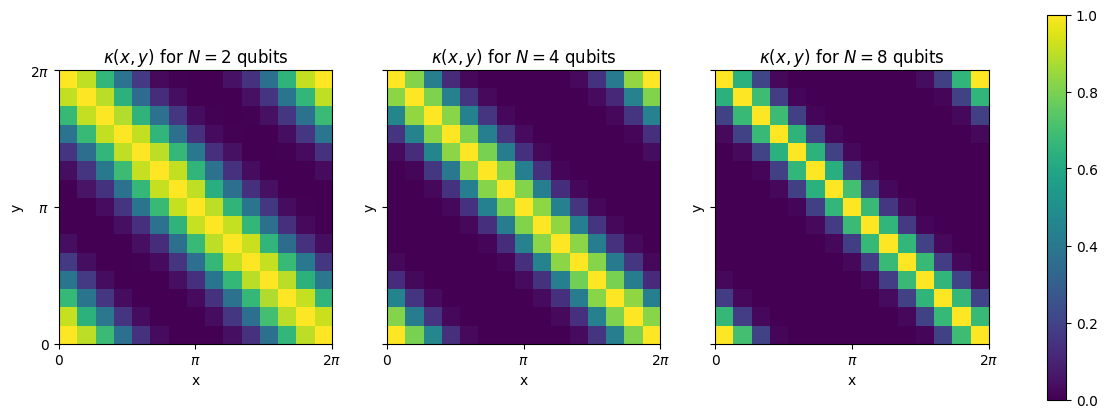

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
k = K_simple_RX(2)
kernel_subplot(axs[0], k, 2)
k = K_simple_RX(4)
kernel_subplot(axs[1], k, 4)
k = K_simple_RX(8)
kernel_subplot(axs[2], k, 8)
# colorbar
fig.colorbar(axs[2].images[0], ax=axs, orientation="vertical")
plt.show()

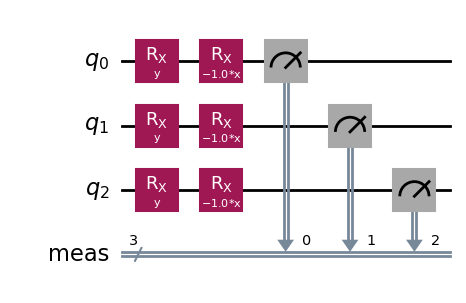

In [16]:
qc = kernel_circuit(3)
qc.decompose().draw(output='mpl', plot_barriers=False,fold=-1)

In [17]:
@qml.qnode(qml.device("default.qubit", wires=3))
def circuit():
    # Since measurements=None, the measurements present in the QuantumCircuit are returned.
    measurements = qml.from_qiskit(qc)(np.pi, np.pi/2)
    return [qml.expval(m) for m in measurements]

# Draw
print(qml.draw(circuit)())

0: ─╭||──┤↗├───────────┤       
1: ─├||───║───┤↗├──────┤       
2: ─╰||───║────║───┤↗├─┤       
          ╚════║════║══╡  <MCM>
               ╚════║══╡  <MCM>
                    ╚══╡  <MCM>


/Users/moritz/anaconda3/envs/AQA_project/lib/python3.12/site-packages/pennylane_qiskit/converter.py:535: UserWarning: pennylane_qiskit.converter: The Instruction instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(


## Results

### $f(x) = x^2$

In [37]:
x = np.linspace(0, 0.1, 51)
y = x**2
data = np.array([x, y])

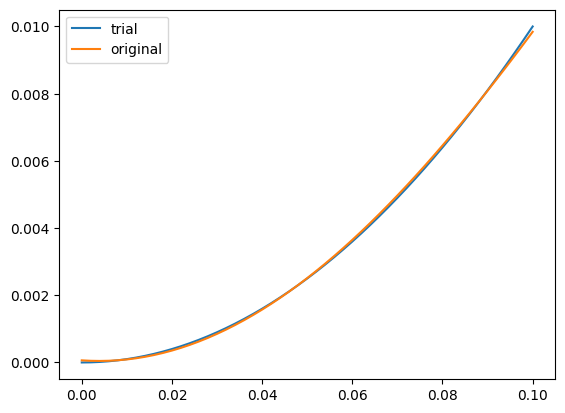

In [38]:
k = K_classical(0.14)
f = method(data, k)
plt.plot(x, y, label="trial")
plt.plot(x, np.array([f(x) for x in x]), label="original")
plt.legend()

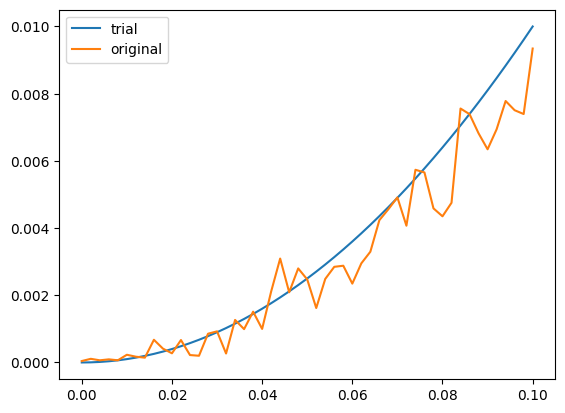

In [41]:
k = K_simple_RX(8)
f = method(data, k)
plt.plot(x, y, label="trial")
plt.plot(x, np.array([f(x) for x in x]), label="original")
plt.legend()

## old code

In [ ]:
N = 3
@qml.qnode(qml.device("default.qubit", wires=N))
def k(x, y):
    for n in range(N):
        qml.RX(x, wires=n)
        qml.adjoint(qml.RX(y, wires=n))
    
    observable = qml.s_prod(1/2, qml.sum(*[
        qml.Identity(wires=range(N)),
        qml.prod(*[qml.PauliZ(wires=i) for i in range(N)])
        ])
    )
    return qml.expval(observable)

In [ ]:
print(qml.draw(k)(np.pi/4, np.pi/2))

0: ──RX(0.79)──RX(1.57)†─┤ ╭<0.50*I+(Z@Z@Z)>
1: ──RX(0.79)──RX(1.57)†─┤ ├<0.50*I+(Z@Z@Z)>
2: ──RX(0.79)──RX(1.57)†─┤ ╰<0.50*I+(Z@Z@Z)>
